In [4]:
#CLV ANALYSIS
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Read the data
data = pd.read_excel('D:/Hackathon_Subject2/DataFiles/output1.3.xlsx')

# 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate snap date
snapshot_date = data['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calcaulate RFM values
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Calculate Recency
    'InvoiceNo': 'nunique',  # Calculate Frequency
    'TotalAmount(£)': 'sum'  # Calculate Monetary Value
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount(£)': 'Monetary'
})

# Assign RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=False) + 1
rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=4, labels=False, duplicates='drop') + 1
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=False) + 1

# Calculate CLV as the product of average purchase value, purchase frequency, and customer lifespan
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency'] * rfm['Recency']

# Segment customers based on CLV
rfm['CLV_Score'] = pd.qcut(rfm['CLV'], q=4, labels=False) + 1

# Analyze CLV for each segment
clv_summary = rfm.groupby('CLV_Score').agg({
    'CLV': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(clv_summary)


# offer loyalty programs to high CLV segments, and targeted promotions to increase CLV for low CLV segments



   CLV_Score           CLV     Recency  Frequency     Monetary
0          1  1.546520e+04   69.331487   1.663897   413.816298
1          2  6.204766e+04  136.346580   2.206100   636.388697
2          3  1.903048e+05  132.603512   3.501848  1256.620887
3          4  2.912706e+06   88.792244   9.617729  6483.054369


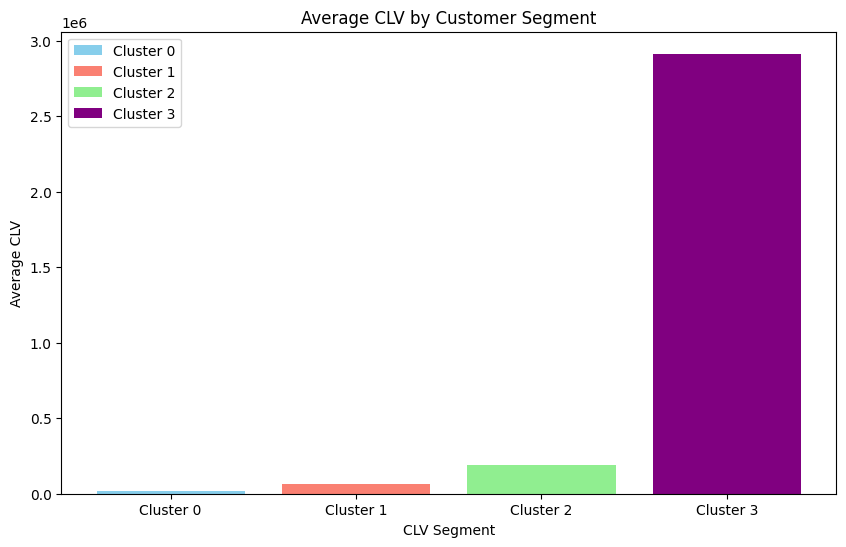

In [25]:
import matplotlib.pyplot as plt

colors = ['skyblue', 'salmon', 'lightgreen', 'purple']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(clv_summary)), clv_summary['CLV'], color=colors)
plt.xlabel('CLV Segment')
plt.ylabel('Average CLV')
plt.title('Average CLV by Customer Segment')
plt.xticks(range(len(clv_summary)), labels=[f'Cluster {i}' for i in range(len(clv_summary))])

# Adding a legend
plt.legend(bars, labels)

plt.show()





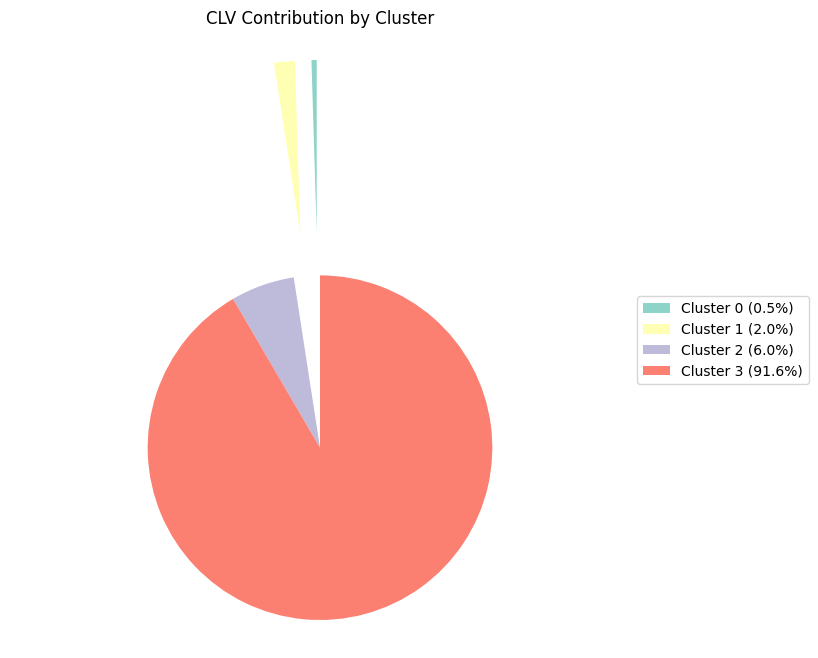

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the total CLV
total_clv = clv_summary['CLV'].sum()

# Calculate the CLV contribution percentage for each segment
clv_contribution = clv_summary['CLV'] / total_clv * 100

# Define which segments to explode more (e.g., segments with less than 5% contribution)
explode = (clv_contribution < 5).astype(float) / 0.8

# Create a pie chart with exploded segments and percentage text outside the pie
plt.figure(figsize=(8, 8))
patches, _, autotexts = plt.pie(clv_contribution, startangle=90, autopct='', colors=sns.color_palette('Set3'), explode=explode)
plt.axis('equal')

# Move the percentage text outside the pie and adjust positions
for autotext, explode_val in zip(autotexts, explode):
    autotext.set_position((1.15 * explode_val, 0))

# Create a custom legend with cluster name and percentage
legend_labels = [f'Cluster {index} ({value:.1f}%)' for index, value in zip(clv_summary.index, clv_contribution)]
plt.legend(handles=patches, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('CLV Contribution by Cluster')
plt.show()

